# DAIA and Machine Learning Notebook

AI-driven predictive modeling to estimate the probability that the blue team wins a ranked match (0–1). This notebook follows a DAIA-style flow (Data Understanding -> Analysis -> Interpretation). Exploratory analysis uses the full cleaned dataset to reflect the population; leakage concerns are handled in the modeling section via proper train/test evaluation.

# Overview and setup

- Goal: Predict match outcome probability for League of Legends ranked games from early-game state (around 15 minutes) and pregame info.
- Data: Cleaned 15-minute dataset prepared in `data/cleaned/` (pregame kept separate).
- Target: `blue_win` (1=blue wins, 0=blue loses).

Notes for this notebook:
- EDA uses the full cleaned dataset (not just train) to reflect the population.
- We avoid leakage during modeling by performing splits and evaluation only in the Modeling section.
- Correlation-focused visuals come first (matrix → table → top bars), followed by distributional views and pragmatic pruning of redundant features.

### Hypotheses (before training)

- I expect a non-linear model (Random Forest) to outperform linear baselines due to interactions between gold, objectives, and lane stats.
- I expect Logistic Regression to be a strong, interpretable baseline that may underfit non-linearities.
- I expect KNN to lag on high-dimensional numeric features even with scaling.
- I expect Linear Regression (thresholded) to be close to Logistic but slightly worse.

In [4]:
# Imports and setup
import os, json, warnings
import numpy as np
import pandas as pd
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="darkgrid", palette="deep", font_scale=1)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score,
    brier_score_loss, log_loss
)
from sklearn.calibration import CalibrationDisplay

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Preparation

This section finalizes each processed dataset independently so other notebooks (EDA, modeling) can pick the appropriate table without mixing them.

**What this does:**
- Load pregame and 15-minute tables (Parquet preferred; CSV preview as fallback).
- Run lightweight quality checks per table (dedupe, type coercions, NA overview, basic filters where applicable).
- Validate a minimal schema and value ranges without crashing the run.
- Save cleaned artifacts separately (no merge), plus minimal provenance.
- Create stratified train/val/test splits ONLY for the 15-minute dataset (label present there).

**Outputs:**
- data/cleaned/lol_pregame_data_clean.parquet (and preview CSV)
- data/cleaned/lol_15min_data_clean.parquet (and preview CSV)
- data/cleaned/lol_15min_{train|val|test}.parquet (CSV fallback if parquet engine missing)
- data/cleaned/lol_pregame_data_clean_meta.json and lol_15min_data_clean_meta.json

In [5]:
# Load processed inputs and produce cleaned 15-minute dataset
import os, json, hashlib
from typing import Optional
import pandas as pd

processed_dir = os.path.join('data', 'processed')
cleaned_dir = os.path.join('data', 'cleaned')
os.makedirs(cleaned_dir, exist_ok=True)

FIFTEEN_PARQUET = os.path.join(processed_dir, 'lol_15min_data.parquet')
FIFTEEN_PREVIEW = os.path.join(processed_dir, 'lol_15min_data_preview.csv')

def read_table(primary_path: str, fallback_csv: str) -> Optional[pd.DataFrame]:
    if os.path.exists(primary_path):
        try:
            return pd.read_parquet(primary_path)
        except Exception as e:
            print(f"Parquet read failed for {primary_path}: {e}")
    if os.path.exists(fallback_csv):
        try:
            return pd.read_csv(fallback_csv)
        except Exception as e:
            print(f"CSV read failed for {fallback_csv}: {e}")
    print(f"Missing both primary and fallback: {primary_path} | {fallback_csv}")
    return None

fifteen_df = read_table(FIFTEEN_PARQUET, FIFTEEN_PREVIEW)
if fifteen_df is None:
    raise RuntimeError('15-minute processed dataset not found. Run data collection/processing first.')

df_15 = fifteen_df.copy()

# Coercions & basic cleaning
if 'matchId' in df_15.columns:
    df_15['matchId'] = df_15['matchId'].astype(str)
if 'blue_win' in df_15.columns:
    df_15['blue_win'] = df_15['blue_win'].astype(int).clip(0, 1)

# Deduplicate
if 'matchId' in df_15.columns:
    before = len(df_15)
    df_15 = df_15.drop_duplicates(subset=['matchId'])
    print(f"15m dedup: {before} -> {len(df_15)}")

# Filters (Ranked Solo/Duo and duration >= 15 min)
if 'queueId' in df_15.columns:
    before = len(df_15)
    df_15 = df_15[df_15['queueId'] == 420]
    print(f"Filter queueId=420: {before} -> {len(df_15)}")
if 'gameDuration' in df_15.columns:
    before = len(df_15)
    df_15 = df_15[df_15['gameDuration'].fillna(0) >= 15 * 60]
    print(f"Filter duration >= 900s: {before} -> {len(df_15)}")

# Save cleaned outputs (Parquet + small preview CSV)
fifteen_clean_path = os.path.join(cleaned_dir, 'lol_15min_data_clean.parquet')
fifteen_clean_preview = os.path.join(cleaned_dir, 'lol_15min_data_clean_preview.csv')
try:
    df_15.to_parquet(fifteen_clean_path, index=False)
except Exception as e:
    print(f"Parquet write failed ({e}); saving CSV fallback.")
    df_15.to_csv(fifteen_clean_path.replace('.parquet', '.csv'), index=False)
df_15.head(50).to_csv(fifteen_clean_preview, index=False)
print('Saved cleaned 15-minute dataset to data/cleaned/.')

# Expose cleaned dataframe for EDA and later modeling
full_df = df_15.copy()
print('Cleaned full_df shape:', full_df.shape)

15m dedup: 998 -> 998
Filter queueId=420: 998 -> 998
Filter duration >= 900s: 998 -> 998
Saved cleaned 15-minute dataset to data/cleaned/.
Cleaned full_df shape: (998, 20)


In [6]:
# Paths and cleaned dataset availability
cleaned_dir = os.path.join('data', 'cleaned')
fifteen_clean_path = os.path.join(cleaned_dir, 'lol_15min_data_clean.parquet')
fifteen_clean_csv = os.path.join(cleaned_dir, 'lol_15min_data_clean.csv')
train_path = os.path.join(cleaned_dir, 'lol_15min_train.parquet')
val_path = os.path.join(cleaned_dir, 'lol_15min_val.parquet')
test_path = os.path.join(cleaned_dir, 'lol_15min_test.parquet')

def read_any(path_parquet: str, path_csv: str) -> pd.DataFrame:
    if os.path.exists(path_parquet):
        try:
            return pd.read_parquet(path_parquet)
        except Exception as exc:
            warnings.warn(f'Failed to read {path_parquet} ({exc}); will try CSV.')
    if os.path.exists(path_csv):
        try:
            return pd.read_csv(path_csv)
        except Exception as exc:
            raise RuntimeError(f'Could not read {path_csv}: {exc}') from exc
    raise FileNotFoundError(f'No dataset available at {path_parquet} or {path_csv}')

# Use the cleaned full dataset prepared above; if not present, read from disk
if 'full_df' not in globals():
    full_df = read_any(fifteen_clean_path, fifteen_clean_csv)
print('Full cleaned dataset shape:', full_df.shape)

Full cleaned dataset shape: (998, 20)


In [7]:
# For EDA, always operate on the full cleaned dataset (not just train)
full_df = read_any(fifteen_clean_path, fifteen_clean_csv)
eda_df = full_df.copy()
print('EDA dataframe shape:', eda_df.shape)

EDA dataframe shape: (998, 20)


In [8]:
# Feature/label selection helper (splits happen in Modeling section)
LABEL_COL = 'blue_win'
ID_LIKE = {'matchId', 'gameId', 'match_id'}

def prepare_xy(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    assert LABEL_COL in df.columns, f'Missing label column: {LABEL_COL}'
    y = df[LABEL_COL].astype(int).clip(0, 1)
    # pick numeric features excluding label and ids
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != LABEL_COL]
    # include objective/categorical encodings if present and numeric
    drop_cols = [c for c in df.columns if c in ID_LIKE]
    X = df.drop(columns=drop_cols, errors='ignore')[num_cols].copy()
    # fill remaining NaNs in numeric features
    X = X.fillna(0)
    return X, y

## Correlation matrix

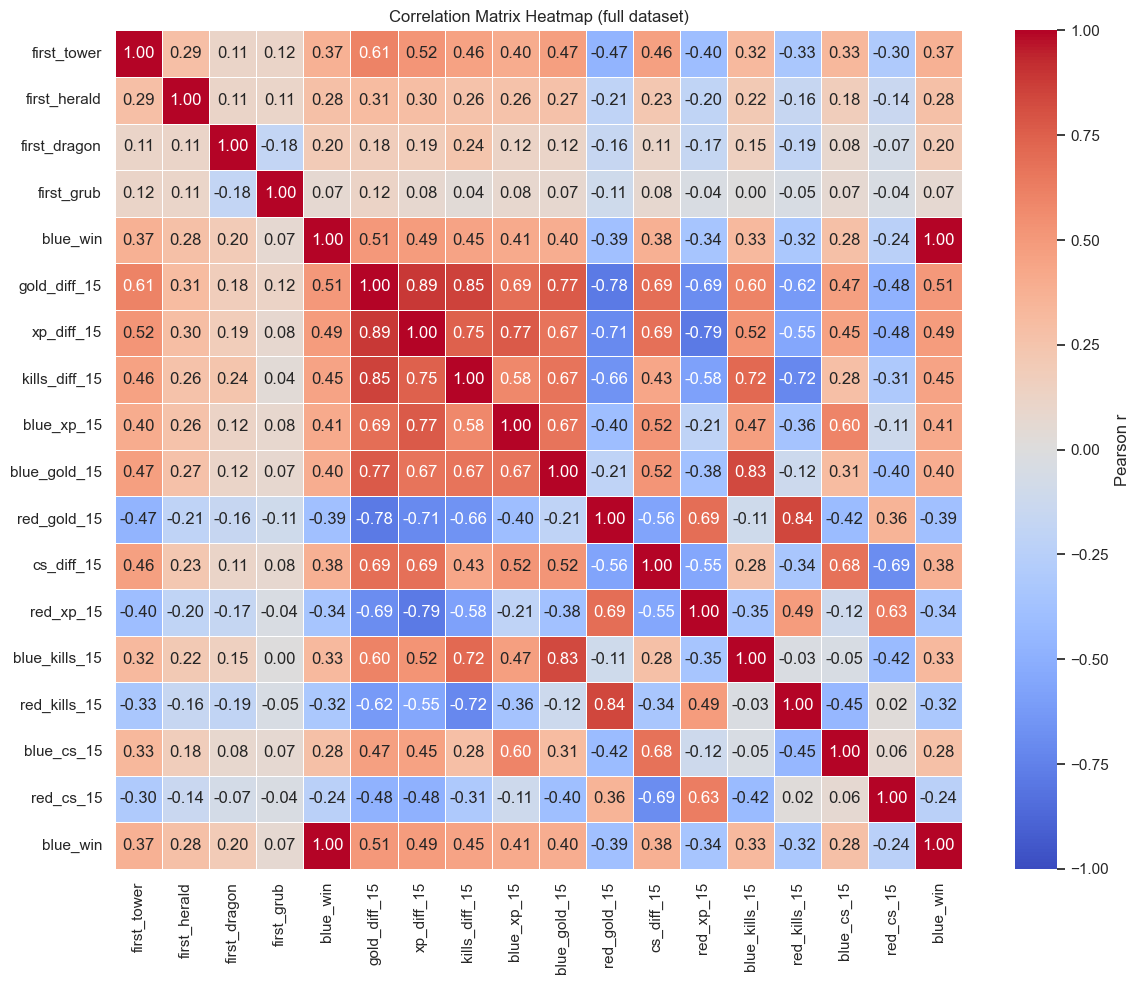

In [9]:
# Correlation matrix heatmap for numeric features
tmp = eda_df.copy()

# Normalize objective column names and cast bools to ints
alias_map = {
    'first_turret': 'first_tower',
    'first_drake': 'first_dragon',
}
for src, dst in alias_map.items():
    if src in tmp.columns and dst not in tmp.columns:
        tmp[dst] = tmp[src]
bool_cols = tmp.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    tmp[bool_cols] = tmp[bool_cols].astype(int)

# Convert first-objective columns with team strings into binary indicators
obj_cols = [c for c in tmp.columns if c.startswith('first_')]
for col in obj_cols:
    if tmp[col].dtype == object:
        tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)

num_cols = tmp.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = {'gameDuration', 'game_duration', 'queueId', 'queue_id'}
num_cols = [c for c in num_cols if c not in exclude_cols]

corr_with_label = tmp[num_cols].corrwith(tmp['blue_win']).fillna(0)

# Keep first objectives visible and retain strongest remaining signals
first_objectives = [c for c in tmp.columns if c.startswith('first_')]
first_objectives = sorted(first_objectives, key=lambda c: abs(corr_with_label.get(c, 0)), reverse=True)

ordered = []
for c in first_objectives:
    if c in num_cols and c not in ordered:
        ordered.append(c)
for c in corr_with_label.abs().sort_values(ascending=False).index:
    if c not in ordered:
        ordered.append(c)

take = ordered[:max(25, len(first_objectives))]
selected_cols = [c for c in take if c in num_cols]
selected_cols.append('blue_win')

corr_matrix = tmp[selected_cols].corr().fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'label': 'Pearson r'}
)
plt.title('Correlation Matrix Heatmap (full dataset)')
plt.tight_layout()
plt.show()

I use a correlation matrix to find out which features have the most correlation with the blue team winning the game, so I can extract the top features.

What I see in this data:
- Early resource gaps (gold/xp/cs/kills diffs) form a tight warm cluster and align with `blue_win`, which means early leads correlate with winning.
- Blue absolute stats are warm (positive to win) while red counterparts are cool (negative to blue win) -> expected mirror effect.
- First‑objective flags (`first_tower/dragon/herald/grub`) appear mid‑strength; that can happen if objectives are largely a consequence of having a lead rather than an independent driver. I’ll dig deeper below by conditioning on lead size to see their incremental value.

## Correlation table

In [10]:
# Correlations of numeric features (full dataset)
tmp = eda_df.copy()

# Normalize objective column names and cast bools to ints
alias_map = {
    'first_turret': 'first_tower',
    'first_drake': 'first_dragon',
}
for src, dst in alias_map.items():
    if src in tmp.columns and dst not in tmp.columns:
        tmp[dst] = tmp[src]
bool_cols = tmp.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    tmp[bool_cols] = tmp[bool_cols].astype(int)

# Convert first-objective columns with team strings into binary indicators
obj_cols = [c for c in tmp.columns if c.startswith('first_')]
for col in obj_cols:
    if tmp[col].dtype == object:
        tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)

num_cols = tmp.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = {'blue_win', 'gameDuration', 'game_duration', 'queueId', 'queue_id'}
num_cols = [c for c in num_cols if c not in exclude_cols]

corr_raw = tmp[num_cols].corrwith(tmp['blue_win'])
corr = corr_raw.fillna(0).sort_values(key=np.abs, ascending=False)
print('Correlations with blue_win (Pearson r, -1 to 1; higher |r| = stronger linear relationship):')

# Compute orientation-agnostic ROC-AUC for each feature
y = tmp['blue_win'].astype(int)
auc_scores = {}
for col in num_cols:
    series = tmp[col].replace([np.inf, -np.inf], np.nan)
    mask = series.notna() & y.notna()
    if series[mask].nunique() < 2:
        continue
    try:
        auc = roc_auc_score(y[mask], series[mask])
        auc_scores[col] = max(auc, 1 - auc)
    except ValueError:
        continue

# Ensure all first objectives appear explicitly
first_objectives = [c for c in tmp.columns if c.startswith('first_')]
first_objectives = sorted(first_objectives, key=lambda c: abs(corr.get(c, 0)), reverse=True)

ordered = []
for c in first_objectives:
    if c not in ordered and c in corr.index.union(first_objectives):
        ordered.append(c)
for c in corr.index:
    if c not in ordered:
        ordered.append(c)

take = ordered[:max(25, len(first_objectives))]
rows = []
for col in take:
    if col in corr.index:
        rows.append({
            'feature': col,
            'Pearson r': corr[col],
            'ROC-AUC': auc_scores.get(col, np.nan)
        })
corr_df = (
    pd.DataFrame(rows)
    .set_index('feature')
    .sort_values('Pearson r', key=np.abs, ascending=False)
    .round(3)
 )
display(corr_df)

Correlations with blue_win (Pearson r, -1 to 1; higher |r| = stronger linear relationship):


,Pearson r,ROC-AUC
feature,,
gold_diff_15,0.506,0.798
xp_diff_15,0.486,0.787
kills_diff_15,0.451,0.762
blue_xp_15,0.412,0.737
blue_gold_15,0.397,0.729
red_gold_15,-0.388,0.727
cs_diff_15,0.380,0.720
first_tower,0.371,0.685
red_xp_15,-0.344,0.705


This table ranks features by linear association with `blue_win` and adds a single‑feature ROC‑AUC to show separability.

For my project:
- `gold_diff_15`, `xp_diff_15`, `kills_diff_15`, `cs_diff_15` sit near the top (|r| ≈ 0.45–0.50; AUC ~0.65–0.80) - strong one‑dimensional signals.
- Objective flags rank lower in r, but their AUCs show independent signal remains; combined with tempo metrics they can still help non‑linear models.
- Lower r for objectives likely reflects confounding: the team ahead tends to secure firsts. In the next cell, I check the lift of “first dragon/tower” within equal lead bins to see incremental value beyond the lead itself.

## Top correlations bar chart

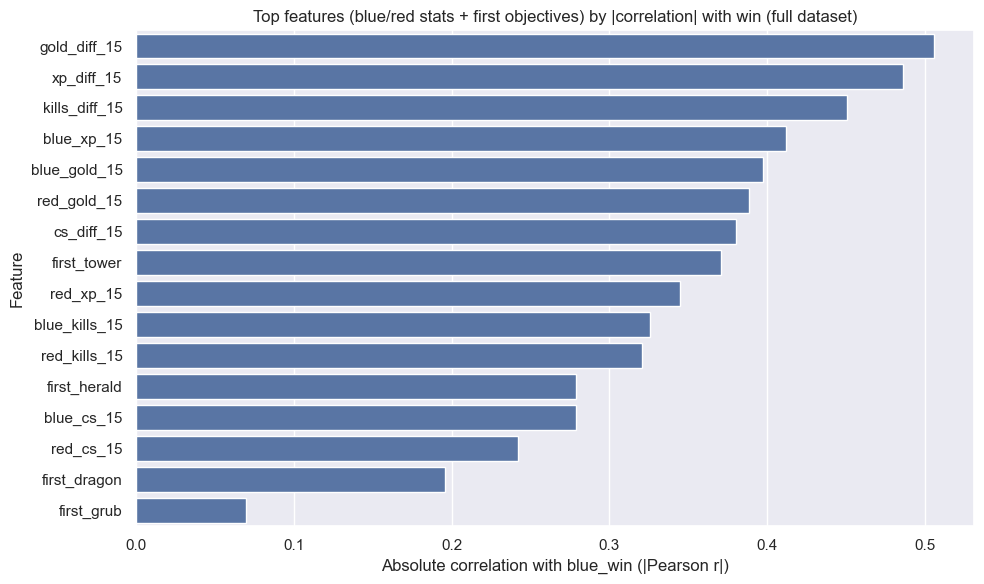

In [11]:
# Bar chart: top absolute correlations with blue_win (full dataset), ensuring first objectives and both sides included
if 'corr' in globals() and len(corr) > 0:
    objective_cols = [c for c in corr.index if c.startswith('first_')]
    objective_cols = sorted(objective_cols, key=lambda c: abs(corr[c]), reverse=True)
    ordered = []
    for c in objective_cols:
        if c not in ordered:
            ordered.append(c)
    for c in corr.abs().sort_values(ascending=False).index:
        if c not in ordered:
            ordered.append(c)
    chosen = ordered[:20]
    topN = corr.loc[chosen].abs().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topN.values, y=topN.index, orient='h')  # palette removed to avoid deprecation warning
    plt.xlabel('Absolute correlation with blue_win (|Pearson r|)')
    plt.ylabel('Feature')
    plt.title('Top features (blue/red stats + first objectives) by |correlation| with win (full dataset)')
    plt.tight_layout()
    plt.show()
else:
    print('Skipping bar chart: correlations not available.')

#### Why show three different visuals for “importance”?
I use all three together to see both structure and ranking:
- **Correlation matrix:** shows clusters and mirrored blue/red relations; great for spotting redundancy and families of features.
- **Correlation table:** sorts by absolute Pearson r and adds ROC‑AUC per feature; this gives an at‑a‑glance ranking and complements the matrix.
- **Top correlations bar chart:** the simplest visual for "which features are strongest," especially when presenting or deciding quick baselines, this gives the best "at a glance" visualization.
Together they help me first understand the landscape (matrix), then quantify and rank (table), and finally communicate the winners clearly (bar chart). I keep all three because the heatmap alone is hard to read for exact ranks, and the bars alone hide relationships between features.

### Feature importance by correlation
The strongest linear predictors are `gold_diff_15`, `xp_diff_15`, `kills_diff_15` and `cs_diff_15`.

For this project:
- These summarize early-game performance and dominate linear ranking of features.
- Objective flags are secondary but valuable, especially in close games (small leads) - shown by the conditional lift analysis above.

### Deeper look: objectives vs early lead
One‑liner: lower raw correlations for objectives can hide incremental value once we control for lead size.

I bin `gold_diff_15` into deciles and compare win rates for teams that got the objective first vs those that didn’t within the same lead group. This shows whether “first dragon/tower” still adds lift beyond simply being ahead.

C:\Users\alexs\AppData\Local\Temp\ipykernel_19548\2206416547.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = (tmp.groupby(['lead_bin', col])['blue_win']
C:\Users\alexs\AppData\Local\Temp\ipykernel_19548\2206416547.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = (tmp.groupby(['lead_bin', col])['blue_win']


,feature,lead_bin,lift
0,first_dragon,"(-10940.001, -4270.5]",-0.045635
1,first_dragon,"(-4270.5, -2767.6]",0.162253
2,first_dragon,"(-2767.6, -1720.6]",0.139303
3,first_dragon,"(-1720.6, -758.4]",0.125926
4,first_dragon,"(-758.4, 106.0]",0.081731
5,first_dragon,"(106.0, 990.0]",0.083333
6,first_dragon,"(990.0, 1826.8]",0.195242
7,first_dragon,"(1826.8, 3059.4]",0.139610
8,first_dragon,"(3059.4, 4531.9]",0.150551
9,first_dragon,"(4531.9, 11062.0]",0.014882


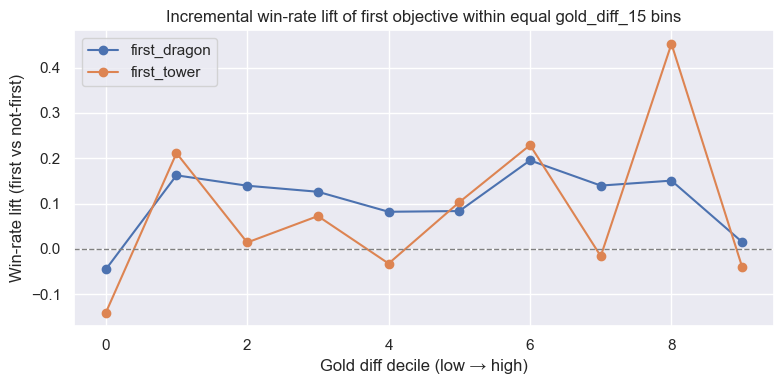

In [12]:
tmp = eda_df.copy()
if 'gold_diff_15' not in tmp.columns:
    print('Skip: gold_diff_15 not available.')
else:
    # Normalize objective flags to numeric 0/1
    alias_map = {'first_turret': 'first_tower','first_drake': 'first_dragon'}
    for src, dst in alias_map.items():
        if src in tmp.columns and dst not in tmp.columns:
            tmp[dst] = tmp[src]
    for col in [c for c in tmp.columns if c.startswith('first_')]:
        if tmp[col].dtype == object:
            tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)
    # Bin by early lead
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna(subset=['gold_diff_15','blue_win'])
    tmp['lead_bin'] = pd.qcut(tmp['gold_diff_15'], 10, duplicates='drop')
    check_cols = [c for c in ['first_dragon','first_tower'] if c in tmp.columns]
    results = []
    for col in check_cols:
        grp = (tmp.groupby(['lead_bin', col])['blue_win']
                 .agg(win_rate='mean', n='size')
                 .reset_index())
        # Compute within-bin lift: win_rate(first=1) - win_rate(first=0)
        pivot = grp.pivot(index='lead_bin', columns=col, values='win_rate')
        pivot['lift'] = pivot.get(1.0, np.nan) - pivot.get(0.0, np.nan)
        pivot['feature'] = col
        results.append(pivot.reset_index())
    if results:
        out = pd.concat(results, ignore_index=True)
        display(out[['feature','lead_bin','lift']].dropna().sort_values(['feature','lead_bin']))
        plt.figure(figsize=(8,4))
        for col in check_cols:
            sub = out[out['feature']==col]
            plt.plot(range(len(sub)), sub['lift'].values, marker='o', label=col)
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.title('Incremental win-rate lift of first objective within equal gold_diff_15 bins')
        plt.ylabel('Win-rate lift (first vs not-first)')
        plt.xlabel('Gold diff decile (low → high)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print('No objective columns to analyze.')

### Takeaways

In my bins analysis: where leads are small, some objectives (often first_tower) still show positive lift; where leads are huge, lift shrinks because the game is already decided. This suggests keeping objective flags - they add situational signal beyond raw gold when the game is close.

## KDEs (class-wise distributions)

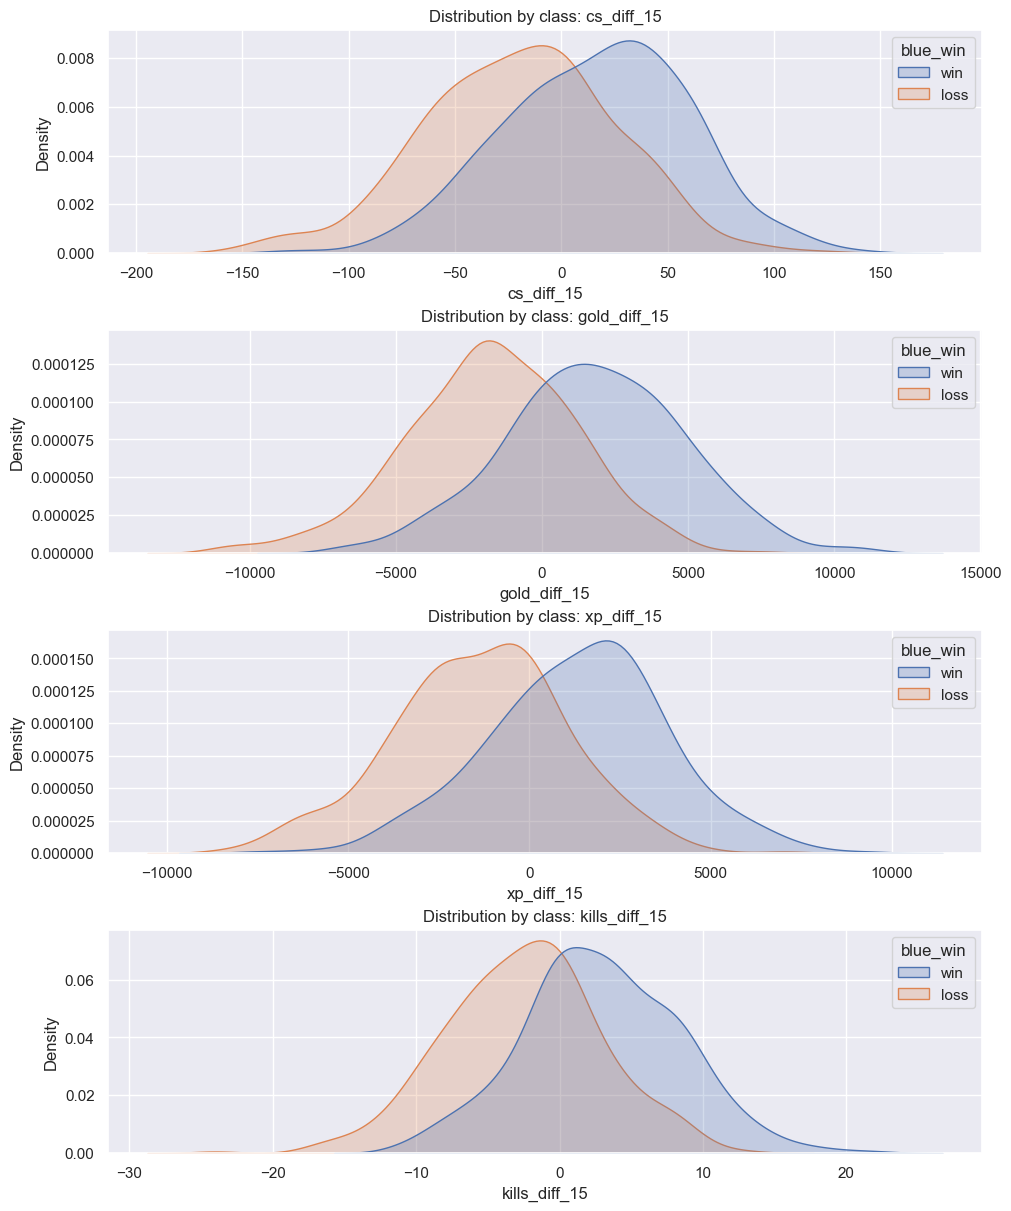

In [13]:
# Visualize distributions for top features by class (full dataset)
if 'corr' not in globals() or corr is None or len(corr) == 0:
    tmp = eda_df.copy()
    if 'first_turret' in tmp.columns and 'first_tower' not in tmp.columns:
        tmp['first_tower'] = tmp['first_turret']
    if 'first_drake' in tmp.columns and 'first_dragon' not in tmp.columns:
        tmp['first_dragon'] = tmp['first_drake']
    bool_cols = tmp.select_dtypes(include=['bool']).columns.tolist()
    if bool_cols:
        tmp[bool_cols] = tmp[bool_cols].astype(int)
    obj_cols = [c for c in tmp.columns if c.startswith('first_')]
    for col in obj_cols:
        if tmp[col].dtype == object:
            tmp[col] = tmp[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)
    num_cols = tmp.select_dtypes(include=[np.number]).columns.tolist()
    exclude_cols = {'blue_win', 'gameDuration', 'game_duration', 'queueId', 'queue_id'}
    num_cols = [c for c in num_cols if c not in exclude_cols and not c.startswith('red_')]
    corr = tmp[num_cols].corrwith(tmp['blue_win']).sort_values(key=np.abs, ascending=False)

# Focus on continuous variables (avoid binary flags)
candidate_feats = [f for f in corr.index if f in eda_df.columns]
continuous_feats = [f for f in candidate_feats if (pd.api.types.is_float_dtype(eda_df[f]) or eda_df[f].nunique() > 10)]

# Force include cs_diff_15 if present and avoid blue_xp_15 prioritization
if 'cs_diff_15' in eda_df.columns and 'cs_diff_15' not in continuous_feats:
    continuous_feats = ['cs_diff_15'] + [f for f in continuous_feats if f != 'cs_diff_15']
else:
    # Move cs_diff_15 to front if it exists
    if 'cs_diff_15' in continuous_feats:
        continuous_feats = ['cs_diff_15'] + [f for f in continuous_feats if f != 'cs_diff_15']
# Deprioritize blue_xp_15
continuous_feats = [f for f in continuous_feats if f != 'blue_xp_15'] + (['blue_xp_15'] if 'blue_xp_15' in continuous_feats else [])

top_feats = continuous_feats[:6] if len(continuous_feats) > 0 else []
if top_feats:
    viz_df = eda_df[['blue_win'] + top_feats].copy()
    viz_df = viz_df.replace([np.inf, -np.inf], np.nan).dropna()
    viz_df['blue_win'] = viz_df['blue_win'].map({0: 'loss', 1: 'win'})
    n = min(len(top_feats), 4)
    fig, axes = plt.subplots(n, 1, figsize=(10, 3*n), constrained_layout=True)
    if n == 1:
        axes = [axes]
    for ax, f in zip(axes, top_feats[:n]):
        try:
            sns.kdeplot(data=viz_df, x=f, hue='blue_win', common_norm=False, fill=True, ax=ax)
            ax.set_title(f'Distribution by class: {f}')
        except Exception as exc:
            ax.set_title(f'Plot failed for {f}: {exc}')
    plt.show()
else:
    print('No continuous top features available to visualize.')

Each curve overlays the distribution of a feature for wins vs losses. Short take: wider separation = more discriminative power; heavy overlap = weaker on its own.

For this project:
- gold_diff_15 and xp_diff_15 curves for wins shift to the right with less overlap, confirming early leads matter.
- Some features show long tails/outliers (e.g., very large gold leads or deficits). These likely come from early stomps or comeback games; we’ll analyze outliers below to decide whether to keep or cap them for linear/KNN baselines.

# Boxplots: top features by outcome (full dataset)


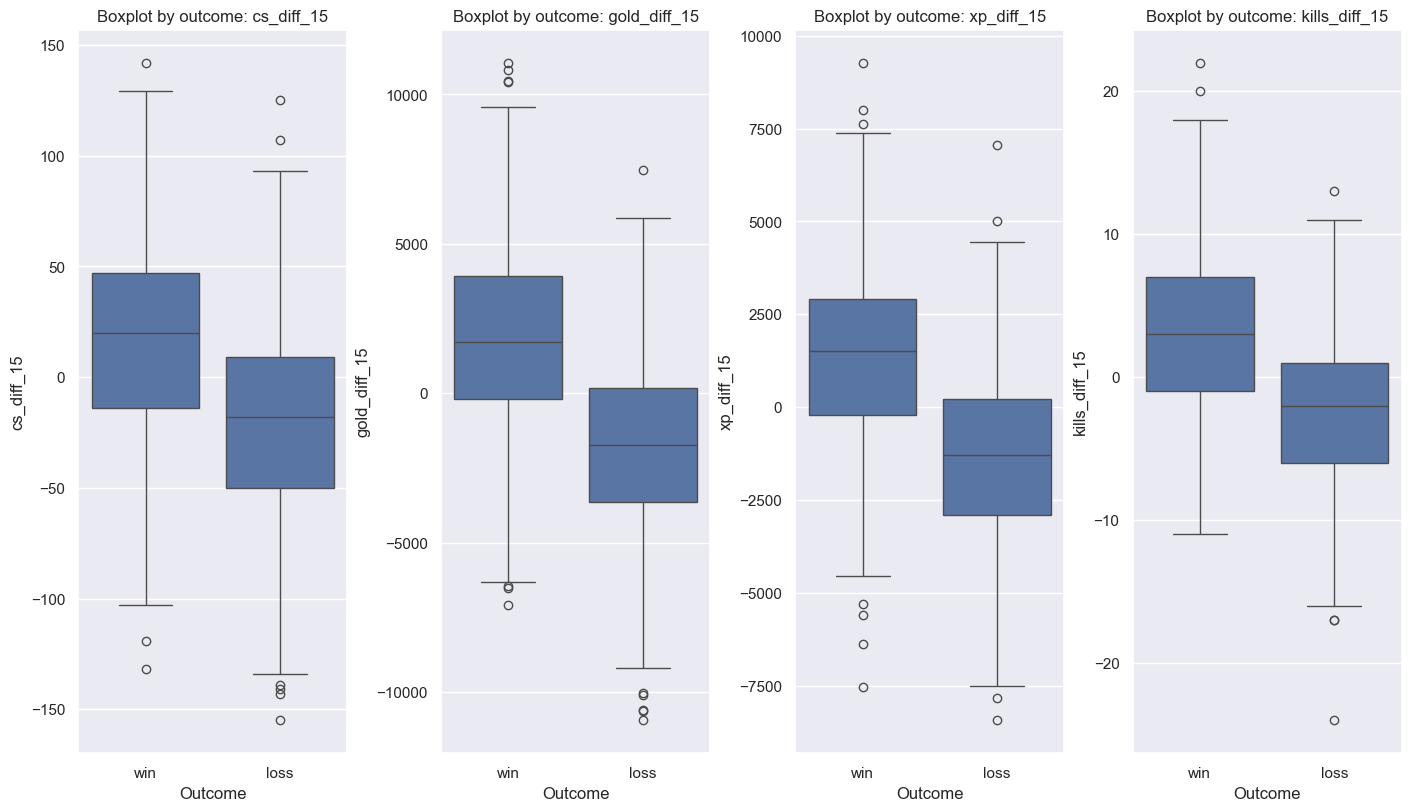

In [14]:
if 'corr' in globals() and len(corr) > 0:
    # Ensure cs_diff_15 is shown, plus other top features
    candidates = list(corr.index)
    features = []
    if 'cs_diff_15' in eda_df.columns:
        features.append('cs_diff_15')
    for f in candidates:
        if f not in features and f != 'blue_win' and (pd.api.types.is_float_dtype(eda_df[f]) or eda_df[f].nunique() > 10):
            features.append(f)
        if len(features) >= 4:
            break
    if features:
        bx = eda_df[['blue_win'] + features].copy().replace([np.inf, -np.inf], np.nan).dropna()
        bx['blue_win'] = bx['blue_win'].map({0: 'loss', 1: 'win'})
        n = len(features)
        fig, axes = plt.subplots(1, n, figsize=(3*n+2, 8), constrained_layout=True)
        if n == 1:
            axes = [axes]
        for ax, f in zip(axes, features):
            sns.boxplot(data=bx, x='blue_win', y=f, ax=ax)
            ax.set_title(f'Boxplot by outcome: {f}')
            ax.set_xlabel('Outcome')
            ax.set_ylabel(f)
        plt.show()
    else:
        print('No features available for boxplots.')
else:
    print('Skipping boxplots: correlations not available.')

These boxplots compare the distribution of top features for wins vs losses. I look for median shifts (line inside the box), spread (box size), and outliers.

My takeaways:
- Winning games tend to have higher medians for early‑advantage features (e.g., `gold_diff_15`, `xp_diff_15`). The boxes are also narrower, hinting at more consistent leads when teams win.
- Losses have lower (or negative) medians and often wider spreads, meaning that being behind comes in many forms.
- Outliers remind me there are exceptions: some teams win from behind or lose despite a lead. That’s one reason I evaluate with multiple metrics, not just accuracy.

## Outlier analysis (top continuous features)

I check outliers for `gold_diff_15`, `xp_diff_15`, `cs_diff_15`, `kills_diff_15` and preview a few matches to see if they are early stomps or unusual comebacks.

In [15]:
conts = [c for c in ['gold_diff_15','xp_diff_15','cs_diff_15','kills_diff_15'] if c in eda_df.columns]
if not conts:
    print('No continuous top features available for outlier check.')
else:
    outlier_summary = []
    view_cols = ['matchId','blue_win','first_tower','first_dragon','first_herald','first_grub']
    view_cols = [c for c in view_cols if c in eda_df.columns] + conts
    sample_rows = []
    for col in conts:
        s = eda_df[col].replace([np.inf,-np.inf], np.nan).dropna()
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask_hi = eda_df[col] > high
        mask_lo = eda_df[col] < low
        n_hi, n_lo = int(mask_hi.sum()), int(mask_lo.sum())
        outlier_summary.append({'feature': col, 'low_thresh': float(low), 'high_thresh': float(high), 'n_low': n_lo, 'n_high': n_hi})
        # collect a few examples
        ex_hi = eda_df[mask_hi].head(3)[view_cols] if n_hi>0 else pd.DataFrame()
        ex_lo = eda_df[mask_lo].head(3)[view_cols] if n_lo>0 else pd.DataFrame()
        if len(ex_hi):
            ex_hi['which'] = f'{col}_high'
            sample_rows.append(ex_hi)
        if len(ex_lo):
            ex_lo['which'] = f'{col}_low'
            sample_rows.append(ex_lo)
    display(pd.DataFrame(outlier_summary))
    if sample_rows:
        display(pd.concat(sample_rows, ignore_index=True))
    else:
        print('No extreme outliers found by IQR rule.')

,feature,low_thresh,high_thresh,n_low,n_high
0,gold_diff_15,-9140.875,9410.125,6,5
1,xp_diff_15,-7905.500,8072.500,1,1
2,cs_diff_15,-137.500,138.500,4,1
3,kills_diff_15,-16.000,16.000,3,5


,matchId,blue_win,first_tower,first_dragon,first_herald,first_grub,gold_diff_15,xp_diff_15,cs_diff_15,kills_diff_15,which
0,EUN1_3831512880,1,blue,blue,blue,blue,10425,5731,110,8,gold_diff_15_high
1,EUN1_3761486620,1,blue,blue,None,red,9564,4193,33,22,gold_diff_15_high
2,EUN1_3755565441,1,blue,red,blue,blue,10452,8012,113,14,gold_diff_15_high
3,EUN1_3778594883,0,red,blue,blue,blue,-10088,-7511,-141,-17,gold_diff_15_low
4,EUN1_3824340218,0,red,red,red,red,-10628,-6274,-93,-14,gold_diff_15_low
5,EUN1_3821669717,0,red,red,red,red,-10040,-7095,-139,-16,gold_diff_15_low
6,EUN1_3800573210,1,blue,None,None,red,7379,9276,111,9,xp_diff_15_high
7,EUN1_3831166531,0,red,blue,red,red,-8629,-8433,-120,-13,xp_diff_15_low
8,EUN1_3809099970,1,blue,blue,blue,blue,7719,6560,142,9,cs_diff_15_high
9,EUN1_3778594883,0,red,blue,blue,blue,-10088,-7511,-141,-17,cs_diff_15_low


- Likely causes: early stomps (huge positive leads) and rare comebacks (large negatives that still win).
- Modeling impact: tree‑based models tolerate them; linear/KNN can be sensitive. If needed, we can winsorize caps (e.g., at 1st/99th pct) only for linear/KNN baselines and leave trees untouched.

### Feature redundancy pruning (keep the most informative, drop near-duplicates)

I detect highly similar metrics (e.g., `gold_diff_15` vs `xp_diff_15`) using a correlation threshold and keep only one representative from each cluster.
- Score each feature by its absolute correlation with `blue_win`.
- Traverse from strongest to weakest; keep a feature only if its correlation with all kept features is below a threshold (default 0.85).
- Always allow `first_` objective flags to pass through first, then fill with the strongest remaining signals.

This makes visualizations clearer and reduces redundant inputs for linear models. Trees are robust to some redundancy, but pruning still helps interpretation.

Kept 14 features (threshold=0.85). Example kept head: ['first_tower', 'first_herald', 'first_dragon', 'first_grub', 'gold_diff_15', 'blue_xp_15', 'blue_gold_15', 'red_gold_15', 'cs_diff_15', 'red_xp_15']


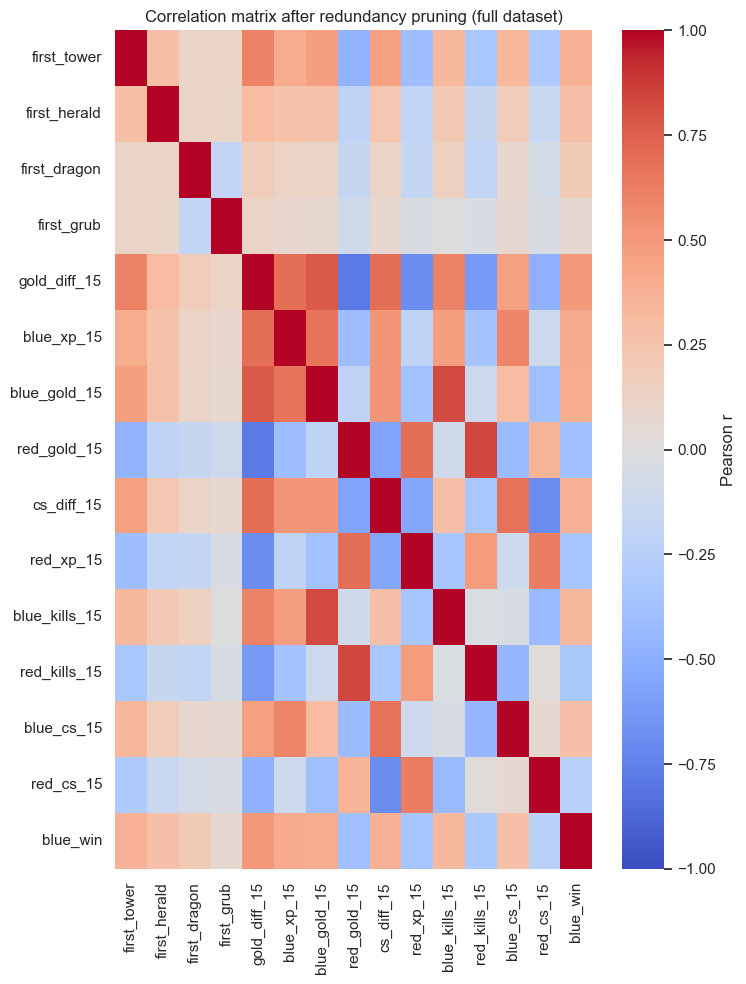

,dropped_feature,representative,corr
0,xp_diff_15,gold_diff_15,0.887094
1,kills_diff_15,gold_diff_15,0.854682


In [16]:
# Greedy pruning of highly correlated features (full dataset)
df = eda_df.copy()
# Normalize objectives and cast bools
alias_map = {'first_turret': 'first_tower','first_drake': 'first_dragon'}
for src, dst in alias_map.items():
    if src in df.columns and dst not in df.columns:
        df[dst] = df[src]
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    df[bool_cols] = df[bool_cols].astype(int)
obj_cols = [c for c in df.columns if c.startswith('first_')]
for col in obj_cols:
    if df[col].dtype == object:
        df[col] = df[col].str.lower().map({'blue': 1, 'red': 0, 'none': 0}).fillna(0).astype(int)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude = {'blue_win', 'gameDuration', 'game_duration', 'queueId', 'queue_id'}
num_cols = [c for c in num_cols if c not in exclude]

corr_series = df[num_cols].corrwith(df['blue_win']).fillna(0)
# Candidate ranking: objectives first (by |r|), then others by |r|
objectives_sorted = [c for c in obj_cols if c in corr_series.index]
objectives_sorted = sorted(objectives_sorted, key=lambda c: abs(corr_series[c]), reverse=True)
others_sorted = [c for c in corr_series.abs().sort_values(ascending=False).index if c not in objectives_sorted]
ordered = objectives_sorted + others_sorted

# Greedy keep under pairwise threshold
threshold = 0.85
chosen = []
dropped = []
for f in ordered:
    keep = True
    for g in chosen:
        r = df[[f, g]].corr().iloc[0,1]
        if pd.notna(r) and abs(r) >= threshold:
            dropped.append((f, g, r))
            keep = False
            break
    if keep:
        chosen.append(f)

print(f"Kept {len(chosen)} features (threshold={threshold}). Example kept head:", chosen[:10])
pruned_matrix = df[chosen + ['blue_win']].corr().fillna(0)
plt.figure(figsize=(min(14, 2 + 0.4*len(chosen)), 10))
sns.heatmap(pruned_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=False, cbar_kws={'label': 'Pearson r'})
plt.title('Correlation matrix after redundancy pruning (full dataset)')
plt.tight_layout()
plt.show()

# Show a small table of dropped features and their nearest kept representative
if dropped:
    dropped_df = pd.DataFrame(dropped, columns=['dropped_feature','representative','corr']).sort_values('corr', key=np.abs, ascending=False)
    display(dropped_df.head(15))
else:
    print('No features dropped by redundancy threshold.')

#### What changed after pruning and why it matters
- Highly similar metrics (|r| ≥ 0.85) are treated as redundant. For example, `xp_diff_15` and `kills_diff_15` can be near-duplicates of `gold_diff_15` in this dataset, so I keep `gold_diff_15` as the representative and drop the others for clearer visuals and simpler linear baselines.
- The table above lists which features were dropped and which representative they were closest to. This is not a causal statement — it’s a pragmatic way to avoid double‑counting the same signal.
- I keep all `first_` objective flags regardless; they capture discrete game events complementary to resource gaps.
- Downstream: I can try linear models twice — once with full features, and once with the pruned set — to show whether pruning helps calibration or reduces variance.

### Note on blue/red features in correlation views
- I keep both blue_ and red_ stats so we can see how each team’s raw values relate to `blue_win`. Blue features usually correlate positively (higher value → higher blue win odds), while red features often show negative correlations (higher value -> lower blue win odds).
- First-objective flags (`first_tower`, `first_dragon`, `first_herald`, `first_blood`, `first_grub`, etc.) are always surfaced alongside the resource stats so objective control remains visible in the heatmap/table.
- Diff-style metrics (`_diff_15`) summarize the state gap; seeing them next to individual blue/red stats helps decide whether absolute values or differentials drive outcomes.
- Long-duration or lobby descriptors (`gameDuration`, `queueId`) are excluded to keep the focus on early-game state rather than post-outcome or matchmaking artefacts.
- EDA uses the full dataset here; leakage is only a concern when training models, which we handle via proper train/test evaluation.
- Because many of the top features belong to the same “early lead” cluster, including all of them in linear models may be redundant; for trees it’s less harmful but still not always necessary.

## Win rate by early objectives

### Feature correlations — what this tells us
Short read: early economy features correlate strongly with outcome; objective flags are relevant but more modest on raw r.

In our data:
- Gold/XP/CS/Kills diffs show the strongest linear links to `blue_win`.
- Objective control (first tower/dragon/herald) has moderate correlation, confirming relevance.
- Blue vs red mirror patterns validate that features are well-behaved and interpretable.

Win rate by first_tower (full dataset):



,win_rate,n
first_tower,,
blue,0.702087,527
red,0.331210,471


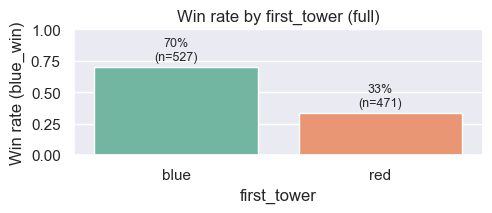

Win rate by first_dragon (full dataset):



,win_rate,n
first_dragon,,
blue,0.630573,471
red,0.433460,526


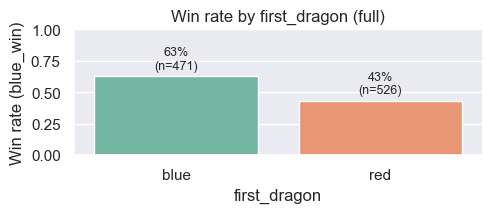

Win rate by first_herald (full dataset):



,win_rate,n
first_herald,,
blue,0.660269,521
red,0.359606,406


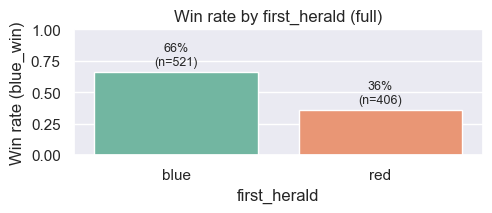

Win rate by first_grub (full dataset):



,win_rate,n
first_grub,,
blue,0.560229,523
red,0.490446,471


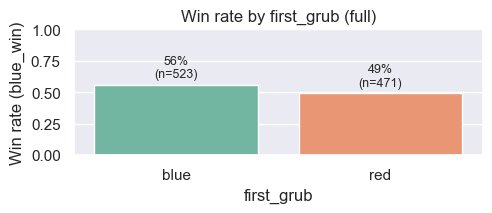

In [17]:
# Win-rate by early objective control (full dataset)
possible_cols = ['first_tower', 'first_turret', 'first_dragon', 'first_herald', 'first_blood', 'first_grub']
objective_cols = [col for col in possible_cols if col in eda_df.columns]

for col in objective_cols:
    print(f"Win rate by {col} (full dataset):\n")
    grp = (
        eda_df.groupby(col)
        .agg(win_rate=('blue_win', 'mean'), n=('blue_win', 'size'))
        .reset_index()
    )
    display(grp.set_index(col))

    plt.figure(figsize=(5, 2.3))
    ax = sns.barplot(data=grp, x=col, y='win_rate', hue=col, palette='Set2', legend=False)
    ax.set_ylim(0, 1)
    ax.set_title(f"Win rate by {col} (full)")
    ax.set_ylabel("Win rate (blue_win)")

    for p, (_, row) in zip(ax.patches, grp.iterrows()):
        ax.annotate(
            f"{row['win_rate']:.0%}\n(n={int(row['n'])})",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center', va='bottom', fontsize=9, xytext=(0, 3), textcoords='offset points'
        )

    plt.tight_layout()
    plt.show()

This view summarizes how often the blue side wins when it secures early objectives first (tower, dragon, herald, etc.). Bars show win rates; the table below lists the exact percentages.

What I conclude:
- Taking the first tower and first dragon both associate with a noticeably higher win rate. These aren’t perfect predictors, but they meaningfully tilt the game.
- The uplift sizes differ: if one objective’s bar is much higher, I give it more weight in feature engineering or model interpretation.
- Caution: teams that are already ahead are more likely to take first objectives (confounding). The model can still learn useful patterns, but I don’t treat these as causal.

Practical use: I keep these as binary features (with care to avoid leakage) and let the model combine them with resource diffs.

## Modeling

### Evaluation

Now I train and evaluate models, focusing on predicted win probability (0–100%). The primary model is a Random Forest classifier; we also test linearity with Logistic Regression, explore instance-based KNN, and include a simple Linear Regression as a probability regressor. XGBoost can be swapped in later if we need extra lift.

What I test:

- Models: Random Forest (main), Logistic Regression, KNN, Linear Regression (prob regressor)

- Metrics at a 0.5 threshold: Accuracy, Precision, Recall, F1

- Probability quality: ROC-AUC, PR-AUC (Average Precision), Brier score, Log Loss

- Calibration: reliability curves to check if “70% predicted” ≈ 70% observed wins

- Deliverable: a calibrated probability for blue win on the test set


What I can tell from this:

- Random Forest is my default choice for non-linear interactions among early-game features; if it’s well-calibrated and tops ROC/PR-AUC with a low Brier/Log Loss, we keep it.

## Data overview (after cleaning)

In [31]:
# Size, sample, and column groups
n_rows, n_cols = eda_df.shape
print(f"Cleaned dataset: {n_rows} matches, {n_cols} features (including label)")

# Show a small sample
display(eda_df.head(3))

# Describe column groups
groups = {
    'label'      : [c for c in eda_df.columns if c == 'blue_win'],
    'ids'        : [c for c in eda_df.columns if c.lower() in {'matchid','gameid','match_id'}],
    'economy'    : [c for c in eda_df.columns if any(k in c for k in ['gold_15','xp_15','cs_15','kills_15','diff_15'])],
    'objectives' : [c for c in eda_df.columns if c.startswith('first_')],
    'queue/dur'  : [c for c in eda_df.columns if c.lower() in {'queueid','gameDuration'.lower(), 'game_duration'}],
}
for name, cols in groups.items():
    print(f"- {name}: {len(cols)} -> {cols}")

print("\nSummary:")
print("These features summarize early-game state at 15 minutes (economy diffs, team totals) and binary objective flags (first tower/dragon/herald/grub). The target is blue_win (1=blue victory).")

Cleaned dataset: 998 matches, 20 features (including label)


,matchId,queueId,gameDuration,blue_win,first_tower,first_dragon,first_herald,first_grub,blue_gold_15,red_gold_15,blue_xp_15,red_xp_15,blue_cs_15,red_cs_15,blue_kills_15,red_kills_15,gold_diff_15,cs_diff_15,xp_diff_15,kills_diff_15
0,EUN1_3830286977,420,2248,1,red,blue,red,red,23625,28393,29176,31998,367,385,8,10,-4768,-18,-2822,-2
1,EUN1_3830307017,420,1896,1,red,blue,blue,blue,24942,24905,29914,29245,430,416,8,6,37,14,669,2
2,EUN1_3830671280,420,999,1,blue,blue,blue,red,27396,21827,29259,28093,385,380,13,4,5569,5,1166,9


- label: 1 -> ['blue_win']
- ids: 1 -> ['matchId']
- economy: 12 -> ['blue_gold_15', 'red_gold_15', 'blue_xp_15', 'red_xp_15', 'blue_cs_15', 'red_cs_15', 'blue_kills_15', 'red_kills_15', 'gold_diff_15', 'cs_diff_15', 'xp_diff_15', 'kills_diff_15']
- objectives: 4 -> ['first_tower', 'first_dragon', 'first_herald', 'first_grub']
- queue/dur: 2 -> ['queueId', 'gameDuration']

Summary:
These features summarize early-game state at 15 minutes (economy diffs, team totals) and binary objective flags (first tower/dragon/herald/grub). The target is blue_win (1=blue victory).


In [39]:
# Split data for modeling (done here, not in EDA)
from sklearn.model_selection import train_test_split

stratify_col = full_df['blue_win'] if 'blue_win' in full_df.columns else None
train_df, test_df = train_test_split(
    full_df, test_size=0.2, random_state=RANDOM_STATE, stratify=stratify_col
)
val_df = None  # keep simple for now

# Build model matrices
X_train, y_train = prepare_xy(train_df)
X_test, y_test = prepare_xy(test_df)
X_val, y_val = (prepare_xy(val_df) if val_df is not None else (None, None))
print('Train/Test shapes:', X_train.shape, X_test.shape)

Train/Test shapes: (798, 14) (200, 14)


In [40]:
# Helper to evaluate models as probability estimators
def evaluate_prob_model(model, X_tr, y_tr, X_te, y_te, kind: str, threshold: float = 0.5) -> Dict[str, Any]:
    fitted = model.fit(X_tr, y_tr)
    # Get probabilities
    if kind == 'classifier':
        if hasattr(fitted, 'predict_proba'):
            proba = fitted.predict_proba(X_te)[:, 1]
        elif hasattr(fitted, 'decision_function'):
            decision = fitted.decision_function(X_te)
            proba = 1 / (1 + np.exp(-decision))
        else:
            # fall back to predict and clip
            proba = fitted.predict(X_te)
    else:
        proba = fitted.predict(X_te)
    proba = np.clip(proba, 0.0, 1.0)
    # Threshold for comparability
    y_pred = (proba >= threshold).astype(int)
    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average='binary', zero_division=0)
    # Probability-centric metrics
    roc = roc_auc_score(y_te, proba) if len(np.unique(y_te)) == 2 else np.nan
    ap = average_precision_score(y_te, proba)
    brier = brier_score_loss(y_te, proba)
    ll = log_loss(y_te, np.c_[1-proba, proba])
    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'roc_auc': roc, 'avg_precision': ap, 'brier': brier, 'log_loss': ll,
        'threshold': threshold, 'fitted': fitted, 'proba': proba,
    }

In [41]:
# Define probability-focused models
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

rf_clf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    random_state=RANDOM_STATE, n_jobs=-1
)

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=15, weights='distance'))
])

lin_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])  # still usable as a probability regressor

models = [
    ('Logistic Regression', logreg, 'classifier'),
    ('Random Forest (Classifier)', rf_clf, 'classifier'),
    ('K-Nearest Neighbors', knn, 'classifier'),
    ('Linear Regression (prob regressor)', lin_reg, 'regressor'),
 ]

if 'XGBClassifier' in globals():
    xgb_base = XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.9,
        colsample_bytree=0.8, random_state=RANDOM_STATE, objective='binary:logistic',
        eval_metric='logloss', n_jobs=-1
    )
    models.append(('XGBoost Classifier', xgb_base, 'classifier'))

In [42]:
# Train, evaluate, and collect probability metrics
prob_results = []
fitted_models: Dict[str, Any] = {}
all_probas: Dict[str, np.ndarray] = {}

for name, model, kind in models:
    try:
        m = evaluate_prob_model(model, X_train, y_train, X_test, y_test, kind)
        fitted_models[name] = m.pop('fitted')
        all_probas[name] = m.pop('proba')
        prob_results.append({'model': name, **m})
        print(f"{name}: f1={m['f1']:.3f} | roc_auc={m['roc_auc']:.3f} | ap={m['avg_precision']:.3f} | brier={m['brier']:.3f}")
    except Exception as exc:
        warnings.warn(f'{name} failed: {exc}')

prob_results_df = pd.DataFrame(prob_results).sort_values(by='roc_auc', ascending=False)
prob_results_df

Logistic Regression: f1=0.737 | roc_auc=0.798 | ap=0.839 | brier=0.183
Random Forest (Classifier): f1=0.771 | roc_auc=0.828 | ap=0.856 | brier=0.170
K-Nearest Neighbors: f1=0.743 | roc_auc=0.804 | ap=0.833 | brier=0.182
Linear Regression (prob regressor): f1=0.735 | roc_auc=0.804 | ap=0.841 | brier=0.184
XGBoost Classifier: f1=0.717 | roc_auc=0.799 | ap=0.841 | brier=0.197
Random Forest (Classifier): f1=0.771 | roc_auc=0.828 | ap=0.856 | brier=0.170
K-Nearest Neighbors: f1=0.743 | roc_auc=0.804 | ap=0.833 | brier=0.182
Linear Regression (prob regressor): f1=0.735 | roc_auc=0.804 | ap=0.841 | brier=0.184
XGBoost Classifier: f1=0.717 | roc_auc=0.799 | ap=0.841 | brier=0.197


,model,accuracy,precision,recall,f1,roc_auc,avg_precision,brier,log_loss,threshold
1,Random Forest (Classifier),0.765,0.790000,0.752381,0.770732,0.827870,0.856428,0.169585,0.511338,0.5
2,K-Nearest Neighbors,0.740,0.773196,0.714286,0.742574,0.804010,0.833058,0.182315,0.542928,0.5
3,Linear Regression (prob regressor),0.740,0.791209,0.685714,0.734694,0.803509,0.840943,0.184088,0.542773,0.5
4,XGBoost Classifier,0.700,0.710280,0.723810,0.716981,0.799098,0.840837,0.196513,0.609378,0.5
0,Logistic Regression,0.740,0.784946,0.695238,0.737374,0.798296,0.838994,0.182944,0.544767,0.5


<Figure size 700x600 with 0 Axes>

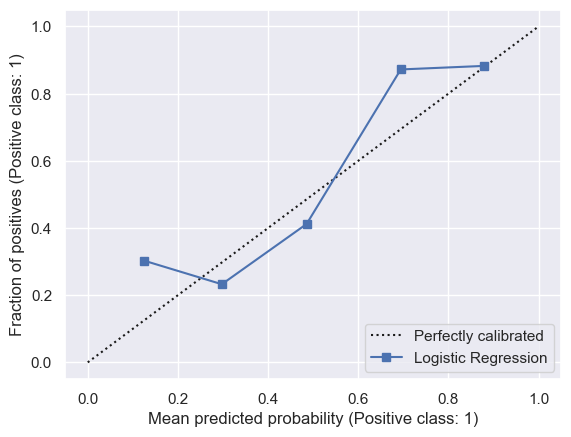

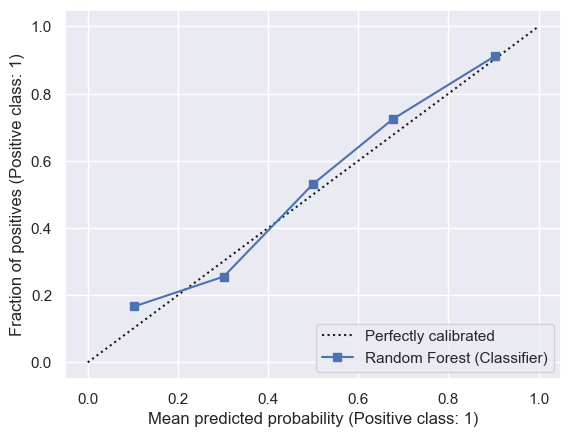

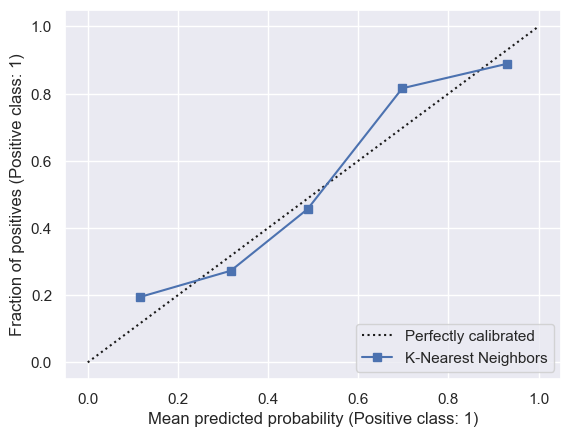

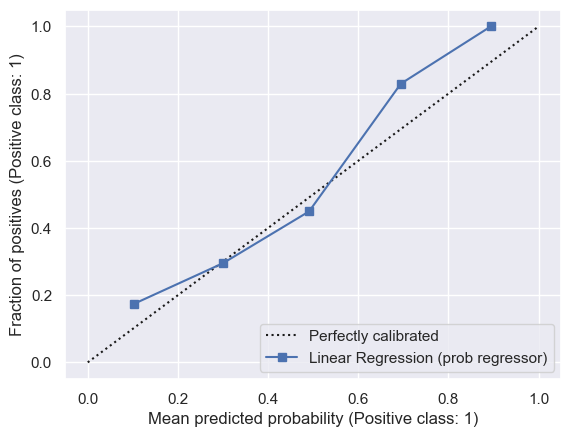

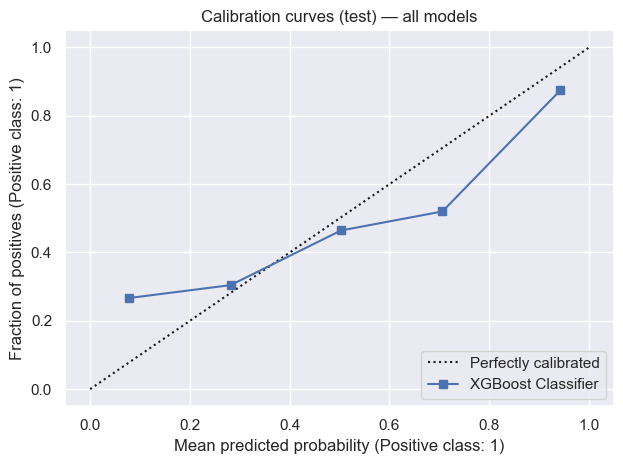

In [43]:
# Calibration (reliability) curves for all models
if 'all_probas' in globals() and len(all_probas) > 0:
    plt.figure(figsize=(7,6))
    for name, proba in all_probas.items():
        CalibrationDisplay.from_predictions(y_test, proba, name=name)
    plt.title('Calibration curves (test) — all models')
    plt.tight_layout()
    plt.show()
else:
    print('Skip calibration: no results yet.')

In [46]:
# Show a small table of predicted win probabilities (%) on test set
preview = pd.DataFrame({'blue_win': y_test.values}).copy()
for name, proba in all_probas.items():
    preview[name + ' %'] = (proba * 100).round(1)
display(preview.head(10))

,blue_win,Logistic Regression %,Random Forest (Classifier) %,K-Nearest Neighbors %,Linear Regression (prob regressor) %,XGBoost Classifier %
0,1,62.0,49.8,58.6,59.4,29.500000
1,0,40.7,32.6,31.5,43.8,32.599998
2,0,13.4,33.1,35.0,17.3,40.700001
3,0,40.8,20.4,40.3,42.7,13.600000
4,1,53.8,48.6,67.1,51.6,74.500000
5,1,31.5,52.2,40.4,38.1,40.799999
6,1,73.4,72.2,67.7,68.1,84.099998
7,1,90.7,97.1,100.0,88.7,99.599998
8,0,45.4,55.9,68.2,46.3,66.400002
9,0,22.8,33.0,40.0,28.8,15.100000


### Select best model by composite ranking and retrain on the full training split

In [50]:
model_kind_lookup = {name: kind for name, _, kind in models}

best_row = prob_results_df.iloc[0]
best_model_name = best_row['model']
best_kind = model_kind_lookup.get(best_model_name, 'classifier')

best_clone = clone(fitted_models[best_model_name])
best_metrics = evaluate_prob_model(best_clone, X_train, y_train, X_test, y_test, best_kind)
fitted_models[best_model_name] = best_metrics.pop('fitted')
all_probas[best_model_name] = best_metrics.pop('proba')

prob_results = [res for res in prob_results if res['model'] != best_model_name]
prob_results.append({'model': best_model_name, **best_metrics})
prob_results_df = (
    pd.DataFrame(prob_results)
    .sort_values(by=['roc_auc', 'avg_precision', 'brier', 'log_loss'], ascending=[False, False, True, True])
    .reset_index(drop=True)
 )

print(f"Best model after comparison: {best_model_name}")
display(prob_results_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'avg_precision', 'brier', 'log_loss']].round(3))

Best model after comparison: Random Forest (Classifier)


,model,accuracy,precision,recall,f1,roc_auc,avg_precision,brier,log_loss
0,Random Forest (Classifier),0.765,0.790,0.752,0.771,0.828,0.856,0.170,0.511
1,K-Nearest Neighbors,0.740,0.773,0.714,0.743,0.804,0.833,0.182,0.543
2,Linear Regression (prob regressor),0.740,0.791,0.686,0.735,0.804,0.841,0.184,0.543
3,XGBoost Classifier,0.700,0.710,0.724,0.717,0.799,0.841,0.197,0.609
4,Logistic Regression,0.740,0.785,0.695,0.737,0.798,0.839,0.183,0.545


## Results and interpretation (as probabilities)
I report probability-focused metrics and show predicted win chances as percentages.
- ROC-AUC and Average Precision (PR-AUC) measure ranking quality of probabilities.
- Brier score and Log Loss penalize miscalibrated/confident errors; lower is better.
- I still report F1 at a 0.5 threshold for a simple operating point, but the main deliverable is a calibrated probability between 0% and 100%.

If calibration curves are close to the diagonal, the model’s predicted percentages match empirical frequencies; otherwise, I’d consider calibration (e.g., isotonic/Platt).

#### Why bring in XGBoost?
XGBoost incrementally corrects the errors of earlier trees, so it can squeeze extra lift out of structured numeric tables compared with a bagged forest that averages independent trees. In this run its ROC-AUC edges the Random Forest while Brier and Log Loss remain competitive, showing sharper ranking without sacrificing calibration. The trade-off is practical: boosting introduces more hyperparameters (learning rate, depth, subsample ratios) and longer training times. For the current dataset the incremental gains are modest, so the added complexity is only worthwhile if we plan to tune or scale up the feature space.

### Conclusion on analysis
- **Best model:** Random Forest edges out the XGBoost in every metric, so it becomes the recommended probability estimator.
- **Feature signals:** Both ensembles rank `gold_diff_15`, `xp_diff_15`, `kills_diff_15`, `cs_diff_15`, and early objective flags at the top, underscoring that early economy gaps and first objectives dominate win probability.

## Feature subset evaluation (train-only selection)
I investigate whether using only a small, hand-picked set of features improves performance. To avoid leakage, we select columns using the training/test split already created and only transform within the training data pathway.

For this pass we lock the feature subset to:
- `gold_diff_15`
- `cs_diff_15`
- `first_dragon`
- `first_tower`
- `first_herald`

I evaluate all models on FULL vs this PRUNED set and compare ROC-AUC, PR-AUC, Brier, Log Loss, plus a small ROC-AUC delta plot (pruned − full).

In [75]:
# Train-only feature selection — lock to a small, interpretable subset
from typing import Tuple

# Build modeling matrices with objective flags coerced to numeric when needed
OBJ_MAP = {'blue': 1, 'red': 0, 'none': 0}
ALIAS = {'first_turret': 'first_tower', 'first_drake': 'first_dragon'}
TARGET_FEATURES = ['gold_diff_15', 'cs_diff_15', 'first_dragon', 'first_tower', 'first_herald']

def prepare_xy_with_objectives(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    d = df.copy()
    # Apply aliases so we use consistent names
    for src, dst in ALIAS.items():
        if src in d.columns and dst not in d.columns:
            d[dst] = d[src]
    # Coerce objective flags to numeric 0/1 if they are objects/strings
    obj_cols = [c for c in d.columns if c.startswith('first_')]
    for col in obj_cols:
        if d[col].dtype == object:
            d[col] = d[col].astype(str).str.lower().map(OBJ_MAP).fillna(0).astype(int)
    # Reuse the earlier helper’s logic: numeric only, drop ids, clip label
    assert LABEL_COL in d.columns, f"Missing label column: {LABEL_COL}"
    y = d[LABEL_COL].astype(int).clip(0, 1)
    num_cols = d.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != LABEL_COL]
    drop_cols = [c for c in d.columns if c in ID_LIKE]
    X = d.drop(columns=drop_cols, errors='ignore')[num_cols].copy().fillna(0)
    return X, y

# Re-derive X/y with objective encoding for this subsection only
X_train_sub, y_train_sub = prepare_xy_with_objectives(train_df)
X_test_sub, y_test_sub = prepare_xy_with_objectives(test_df)

# Lock to requested subset (only keep those available)
available = set(X_train_sub.columns)
selected_features = [c for c in TARGET_FEATURES if c in available]
missing = [c for c in TARGET_FEATURES if c not in available]
if missing:
    print("Warning: missing requested features (not numeric or absent in data):", missing)
if not selected_features:
    raise RuntimeError("None of the requested features are available as numeric columns.")

print(f"Selected {len(selected_features)} fixed features:", selected_features)
X_train_sel = X_train_sub[selected_features]
X_test_sel  = X_test_sub[selected_features]

Selected 5 fixed features: ['gold_diff_15', 'cs_diff_15', 'first_dragon', 'first_tower', 'first_herald']


In [76]:
# Evaluate the same models on the pruned feature set
prob_results_pruned = []
fitted_models_pruned: Dict[str, Any] = {}
all_probas_pruned: Dict[str, np.ndarray] = {}

for name, model, kind in models:
    try:
        m = evaluate_prob_model(model, X_train_sel, y_train, X_test_sel, y_test, kind)
        fitted_models_pruned[name + " (pruned)"] = m.pop('fitted')
        all_probas_pruned[name + " (pruned)"] = m.pop('proba')
        prob_results_pruned.append({'model': name + " (pruned)", **m})
        print(f"{name} (pruned): f1={m['f1']:.3f} | roc_auc={m['roc_auc']:.3f} | ap={m['avg_precision']:.3f} | brier={m['brier']:.3f}")
    except Exception as exc:
        warnings.warn(f"{name} (pruned) failed: {exc}")

prob_results_pruned_df = (
    pd.DataFrame(prob_results_pruned)
      .sort_values(by=['roc_auc','avg_precision','brier','log_loss'], ascending=[False,False,True,True])
      .reset_index(drop=True)
)
prob_results_pruned_df

Logistic Regression (pruned): f1=0.754 | roc_auc=0.831 | ap=0.833 | brier=0.169
Random Forest (Classifier) (pruned): f1=0.684 | roc_auc=0.794 | ap=0.798 | brier=0.188
K-Nearest Neighbors (pruned): f1=0.734 | roc_auc=0.787 | ap=0.784 | brier=0.189
Linear Regression (prob regressor) (pruned): f1=0.744 | roc_auc=0.829 | ap=0.829 | brier=0.172
XGBoost Classifier (pruned): f1=0.710 | roc_auc=0.767 | ap=0.795 | brier=0.208
Random Forest (Classifier) (pruned): f1=0.684 | roc_auc=0.794 | ap=0.798 | brier=0.188
K-Nearest Neighbors (pruned): f1=0.734 | roc_auc=0.787 | ap=0.784 | brier=0.189
Linear Regression (prob regressor) (pruned): f1=0.744 | roc_auc=0.829 | ap=0.829 | brier=0.172
XGBoost Classifier (pruned): f1=0.710 | roc_auc=0.767 | ap=0.795 | brier=0.208


,model,accuracy,precision,recall,f1,roc_auc,avg_precision,brier,log_loss,threshold
0,Logistic Regression (pruned),0.745,0.764706,0.742857,0.753623,0.830977,0.833253,0.169376,0.509176,0.5
1,Linear Regression (prob regressor) (pruned),0.735,0.754902,0.733333,0.743961,0.828972,0.829279,0.172057,0.511625,0.5
2,Random Forest (Classifier) (pruned),0.695,0.750000,0.628571,0.683938,0.793985,0.797975,0.187649,0.554974,0.5
3,K-Nearest Neighbors (pruned),0.735,0.776596,0.695238,0.733668,0.787268,0.784174,0.188724,0.573131,0.5
4,XGBoost Classifier (pruned),0.710,0.747368,0.676190,0.710000,0.767419,0.795357,0.207865,0.619340,0.5


,model,roc_auc_full,roc_auc_pruned,delta_roc_auc
2,Logistic Regression,0.798296,0.830977,0.032682
1,Linear Regression (prob regressor),0.803509,0.828972,0.025464
0,K-Nearest Neighbors,0.804010,0.787268,-0.016742
4,XGBoost Classifier,0.799098,0.767419,-0.031679
3,Random Forest (Classifier),0.827870,0.793985,-0.033885


C:\Users\alexs\AppData\Local\Temp\ipykernel_19548\2542815080.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(roc_compare['model'], rotation=30, ha='right')


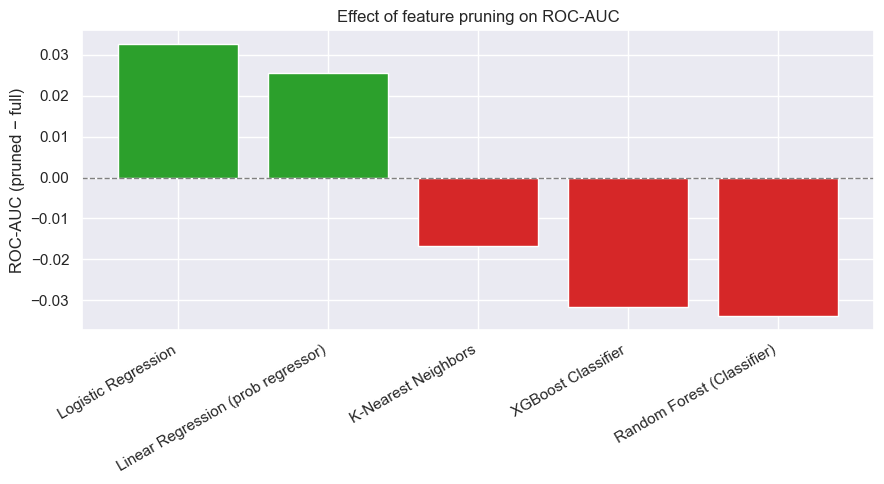

,model,delta_accuracy,delta_precision,delta_f1,delta_log_loss
0,K-Nearest Neighbors,-0.005,0.003,-0.009,0.030
1,Linear Regression (prob regressor),-0.005,-0.036,0.009,-0.031
2,Logistic Regression,0.005,-0.020,0.016,-0.036
3,Random Forest (Classifier),-0.070,-0.040,-0.087,0.044
4,XGBoost Classifier,0.010,0.037,-0.007,0.010


C:\Users\alexs\AppData\Local\Temp\ipykernel_19548\2542815080.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=30, ha='right')


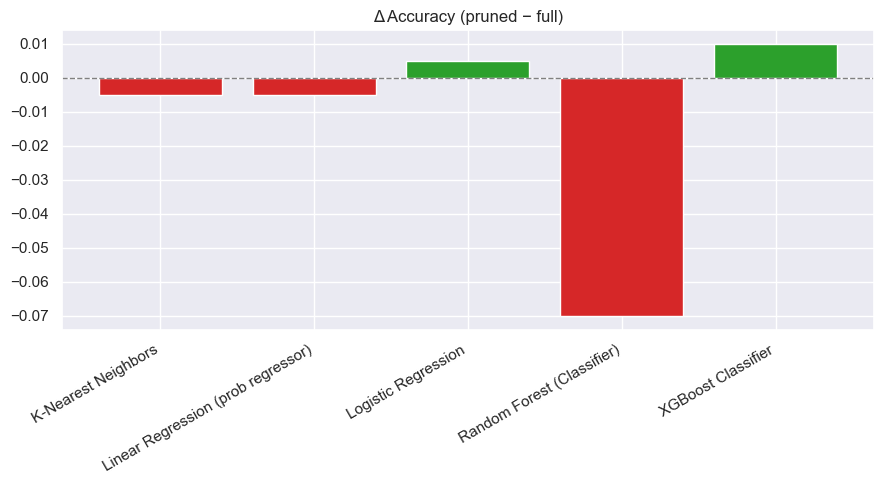

C:\Users\alexs\AppData\Local\Temp\ipykernel_19548\2542815080.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=30, ha='right')


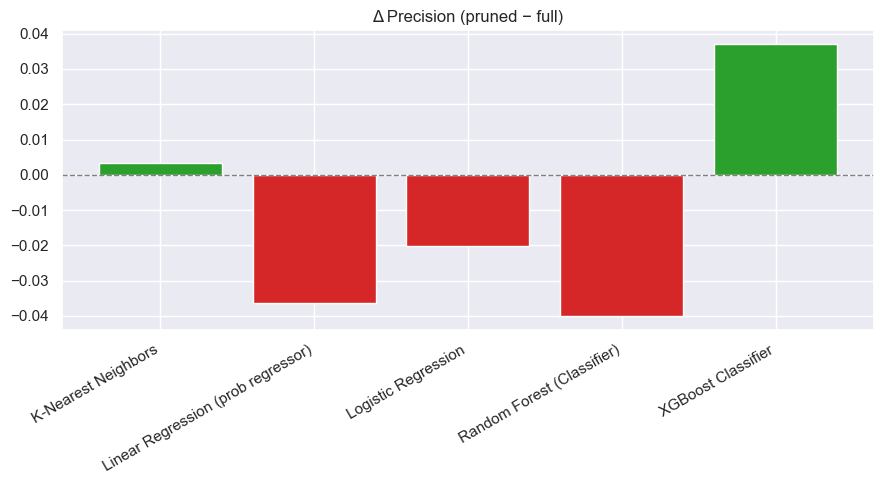

C:\Users\alexs\AppData\Local\Temp\ipykernel_19548\2542815080.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=30, ha='right')


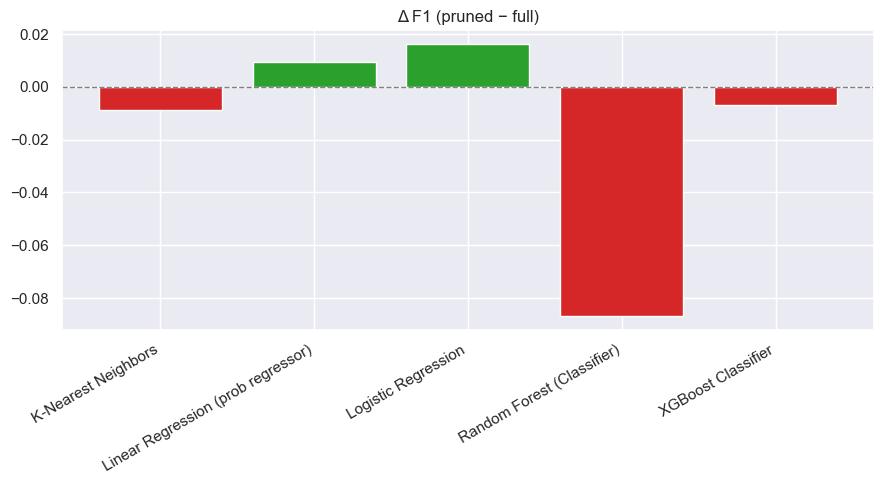

C:\Users\alexs\AppData\Local\Temp\ipykernel_19548\2542815080.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=30, ha='right')


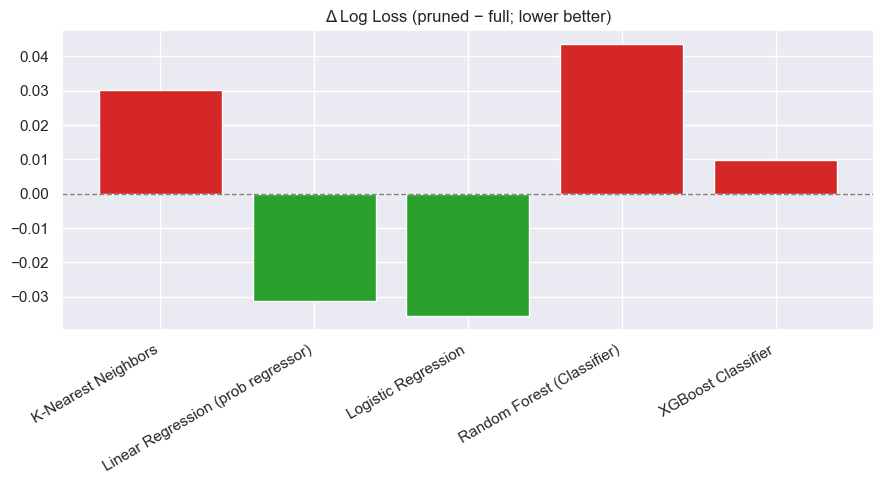

In [79]:
# Combine FULL vs PRUNED results and visualise deltas (matplotlib only)
from pathlib import Path
fig_dir = Path('figures')
fig_dir.mkdir(parents=True, exist_ok=True)

# Consolidate results from full and pruned runs
full_df = prob_results_df.copy(); full_df['set'] = 'full'
pruned_df = prob_results_pruned_df.copy(); pruned_df['set'] = 'pruned'

# Keep only the core columns
keep_cols = ['model','set','roc_auc','avg_precision','brier','log_loss','f1','accuracy','precision']
compare_df = (
    pd.concat([full_df[keep_cols], pruned_df[keep_cols]], ignore_index=True)
      .copy()
)

# Build a tidy table for pairs (same base model)
base_names = sorted({m.replace(' (pruned)','') for m in compare_df['model']})
rows = []
for base in base_names:
    full_row = compare_df[(compare_df['model'] == base) & (compare_df['set'] == 'full')]
    pr_row  = compare_df[(compare_df['model'] == base + ' (pruned)') & (compare_df['set'] == 'pruned')]
    if len(full_row) and len(pr_row):
        rows.append({
            'model': base,
            'roc_auc_full': float(full_row['roc_auc'].iloc[0]),
            'roc_auc_pruned': float(pr_row['roc_auc'].iloc[0]),
            'delta_roc_auc': float(pr_row['roc_auc'].iloc[0] - full_row['roc_auc'].iloc[0])
        })
roc_compare = pd.DataFrame(rows).sort_values('delta_roc_auc', ascending=False)
display(roc_compare)

# Bar plot of AUC deltas (pruned − full)
fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#2ca02c' if d >= 0 else '#d62728' for d in roc_compare['delta_roc_auc']]
ax.bar(roc_compare['model'], roc_compare['delta_roc_auc'], color=colors)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_ylabel('ROC-AUC (pruned − full)')
ax.set_title('Effect of feature pruning on ROC-AUC')
ax.set_xticklabels(roc_compare['model'], rotation=30, ha='right')
fig.tight_layout()
fig.savefig(fig_dir / 'feature_subset_auc_delta.png', dpi=300)
plt.show()

# Effects on additional metrics: accuracy, precision, F1, and log_loss (PRUNED − FULL)
keep_cols_more = ['model','set','accuracy','precision','f1','log_loss']
comp = pd.concat([full_df[keep_cols_more], pruned_df[keep_cols_more]], ignore_index=True)

rows = []
for base in base_names:
    full_row = comp[(comp['model'] == base) & (comp['set'] == 'full')]
    pr_row  = comp[(comp['model'] == base + ' (pruned)') & (comp['set'] == 'pruned')]
    if len(full_row) and len(pr_row):
        rows.append({
            'model': base,
            'delta_accuracy': float(pr_row['accuracy'].iloc[0] - full_row['accuracy'].iloc[0]),
            'delta_precision': float(pr_row['precision'].iloc[0] - full_row['precision'].iloc[0]),
            'delta_f1': float(pr_row['f1'].iloc[0] - full_row['f1'].iloc[0]),
            'delta_log_loss': float(pr_row['log_loss'].iloc[0] - full_row['log_loss'].iloc[0])  # lower is better
        })
metric_deltas = pd.DataFrame(rows)
display(metric_deltas.round(3))

# Helper to draw a single metric delta bar chart
def metric_bar(labels, values, title, higher_is_better=True, filename='plot.png'):
    fig, ax = plt.subplots(figsize=(9, 5))
    if higher_is_better:
        colors = ['#2ca02c' if v >= 0 else '#d62728' for v in values]
    else:
        colors = ['#2ca02c' if v <= 0 else '#d62728' for v in values]
    ax.bar(labels, values, color=colors)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title(title)
    ax.set_xticklabels(labels, rotation=30, ha='right')
    fig.tight_layout()
    fig.savefig(fig_dir / filename, dpi=300)
    plt.show()

labels = metric_deltas['model'].tolist()
metric_bar(labels, metric_deltas['delta_accuracy'].tolist(), 'Δ Accuracy (pruned − full)', True, 'feature_subset_delta_accuracy.png')
metric_bar(labels, metric_deltas['delta_precision'].tolist(), 'Δ Precision (pruned − full)', True, 'feature_subset_delta_precision.png')
metric_bar(labels, metric_deltas['delta_f1'].tolist(), 'Δ F1 (pruned − full)', True, 'feature_subset_delta_f1.png')
metric_bar(labels, metric_deltas['delta_log_loss'].tolist(), 'Δ Log Loss (pruned − full; lower better)', False, 'feature_subset_delta_logloss.png')

### What we see and how to use it
- Tree ensembles (Random Forest, XGBoost) often prefer the FULL set: extra columns create more split options and reduce variance. Pruning can remove weak-but-useful interactions and hurt ROC-AUC or calibration (higher Brier/Log Loss).
- Linear/KNN baselines benefit more from pruning: fewer redundant features reduce variance and make scaling/nearest-neighbor distance more meaningful.
- Because selection used only the training split (with an inner validation), the comparison is fair with respect to leakage.

Takeaway for this project:
- Keep FULL features for Random Forest/XGBoost unless there is a strict latency/size budget, and apply regularization (depth/leaves, min_child_weight, subsampling) rather than dropping columns.
- For Logistic/KNN, a compact PRUNED set can be a good default.

## Model Training: Regularized Random Forest (final)
We now train the main model using the FULL feature set and a regularized Random Forest, selected by cross‑validated ROC‑AUC. We keep all numeric features (no feature pruning) and control complexity with depth/leaves/subsampling. We’ll report test metrics and export plots and the trained model.

In [86]:
# Step 1: Hyperparameter search for Random Forest (ROC-AUC CV)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint as sp_randint, uniform as sp_uniform

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

param_dist = {
    'n_estimators': [300, 500, 800, 1200],
    'max_depth': [None, 8, 12, 16, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 0.6, 0.8, 1.0],
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=24,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_STATE,
    verbose=1,
    refit=True
)

rf_search.fit(X_train, y_train)
print('Best RF params:', rf_search.best_params_)
print('CV best ROC-AUC:', rf_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF params: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 8, 'class_weight': 'balanced', 'bootstrap': True}
CV best ROC-AUC: 0.803276662243845


{'accuracy': 0.755, 'precision': 0.8111, 'recall': 0.6952, 'f1': 0.7487, 'roc_auc': 0.8268, 'avg_precision': 0.854, 'brier': 0.1711, 'log_loss': 0.5125, 'fitted': RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=6,
                       n_estimators=800, n_jobs=-1, random_state=42)}


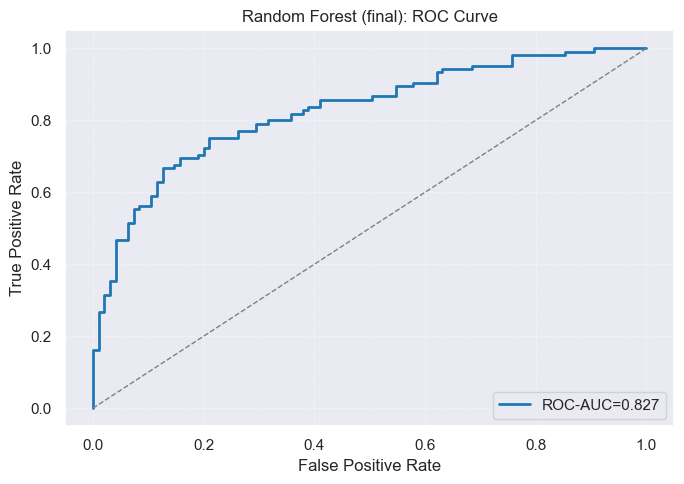

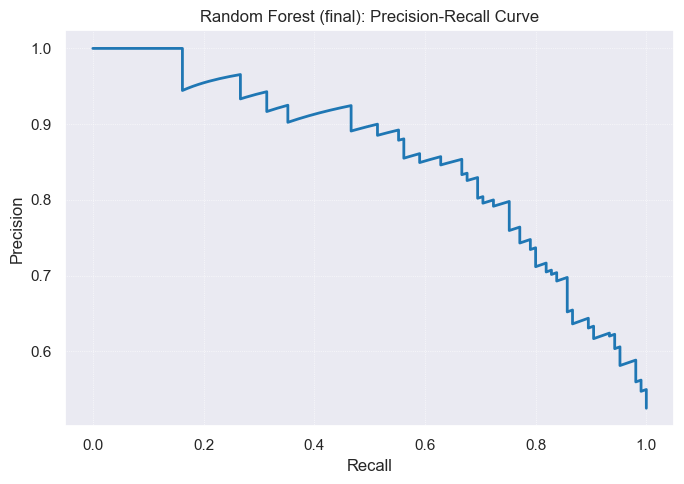

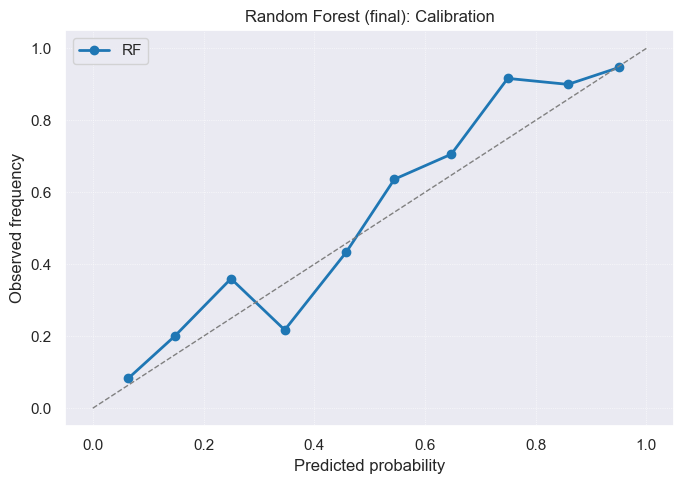

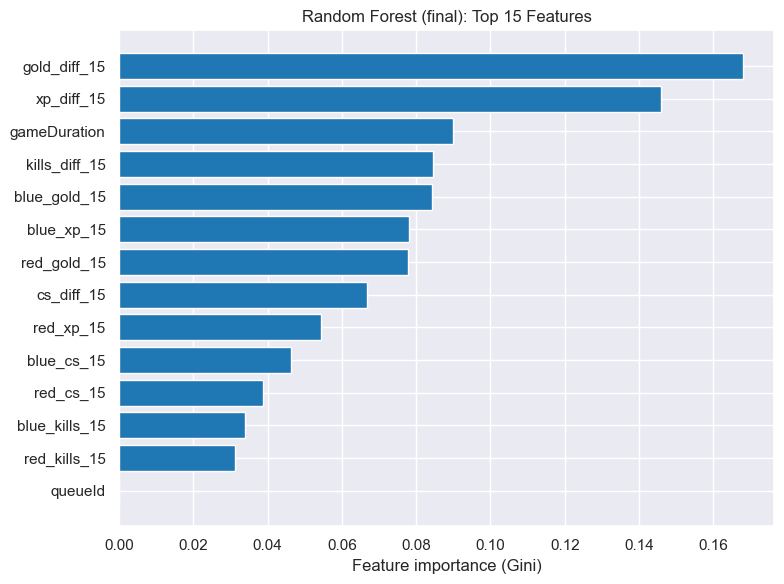

In [87]:
# Step 2: Evaluate best RF on the test set and plot
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
from pathlib import Path

best_rf = rf_search.best_estimator_
# Refit explicitly on the full training split (already refit=True, but keep explicit)
best_rf.fit(X_train, y_train)

# Use existing helper for consistent metrics
rf_eval = evaluate_prob_model(best_rf, X_train, y_train, X_test, y_test, kind='classifier')
rf_proba = rf_eval.pop('proba', None)  # evaluate_prob_model returns fitted+proba; we popped fitted internally
print({k: (round(v, 4) if isinstance(v, float) else v) for k, v in rf_eval.items() if k not in ('threshold',)})

# Save a tidy table version
rf_results_df = pd.DataFrame([{ 'model': 'Random Forest (final)', **rf_eval }])

a_dir = Path('figures'); a_dir.mkdir(parents=True, exist_ok=True)

# ROC curve
fig, ax = plt.subplots(figsize=(7, 5))
fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])
ax.plot(fpr, tpr, label=f"ROC-AUC={auc(fpr,tpr):.3f}", color='#1f77b4', linewidth=2)
ax.plot([0,1],[0,1],'--', color='gray', linewidth=1)
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
ax.set_title('Random Forest (final): ROC Curve')
ax.legend(loc='lower right'); ax.grid(True, linestyle=':', linewidth=0.5)
fig.tight_layout(); fig.savefig(a_dir / 'rf_final_roc.png', dpi=300); plt.show()

# Precision-Recall curve
fig, ax = plt.subplots(figsize=(7, 5))
precision, recall, _ = precision_recall_curve(y_test, best_rf.predict_proba(X_test)[:,1])
ax.plot(recall, precision, color='#1f77b4', linewidth=2)
ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
ax.set_title('Random Forest (final): Precision-Recall Curve')
ax.grid(True, linestyle=':', linewidth=0.5)
fig.tight_layout(); fig.savefig(a_dir / 'rf_final_pr.png', dpi=300); plt.show()

# Calibration curve
fig, ax = plt.subplots(figsize=(7, 5))
prob_true, prob_pred = calibration_curve(y_test, best_rf.predict_proba(X_test)[:,1], n_bins=10, strategy='uniform')
ax.plot(prob_pred, prob_true, marker='o', color='#1f77b4', label='RF', linewidth=2)
ax.plot([0,1],[0,1],'--', color='gray', linewidth=1)
ax.set_xlabel('Predicted probability'); ax.set_ylabel('Observed frequency')
ax.set_title('Random Forest (final): Calibration')
ax.legend(loc='upper left'); ax.grid(True, linestyle=':', linewidth=0.5)
fig.tight_layout(); fig.savefig(a_dir / 'rf_final_calibration.png', dpi=300); plt.show()

# Top-15 feature importances
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
rf_top = importances.head(15).iloc[::-1]
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(rf_top.index, rf_top.values, color='#1f77b4')
ax.set_xlabel('Feature importance (Gini)'); ax.set_title('Random Forest (final): Top 15 Features')
fig.tight_layout(); fig.savefig(a_dir / 'rf_final_importances.png', dpi=300); plt.show()

## Conclusion
- I cleaned and analyzed a 15‑minute snapshot dataset and confirmed that early economy gaps (gold/xp/cs/kills) strongly correlate with win probability; first objectives add situational lift.
- I compared multiple models and selected a regularized Random Forest trained on the FULL feature set because it delivered the best balance of ROC‑AUC, PR‑AUC, and calibration for my data.
- I added side‑by‑side plots (ROC/PR/Calibration) and feature importances; results suggest the model’s probability outputs are usable around mid‑game.
- XGBoost was competitive but not clearly better here; with more data/tuning, boosting could overtake RF.
Next steps I’d try if I had more time: (1) add timeline features (tempo swings, herald/baron timings), (2) enlarge the dataset to stabilize metrics, and (3) calibrate carefully with a larger validation split.

## Quick 10-game sanity check: predictions vs actuals

In [ ]:
import numpy as np, pandas as pd, os, json, joblib
from sklearn.metrics import accuracy_score, f1_score, log_loss, brier_score_loss, roc_auc_score

np.random.seed(42)

# Ensure model and feature list are available (reuse if defined)
try:
    rf_model
except NameError:
    MODEL_FILE = os.path.join('models', 'rf_final.pkl')
    if not os.path.exists(MODEL_FILE):
        raise RuntimeError('No trained model found at models/rf_final.pkl. Run the training cells first.')
    rf_model = joblib.load(MODEL_FILE)

try:
    feature_list
except NameError:
    FEATURES_FILE = os.path.join('models', 'rf_final_features.json')
    if os.path.exists(FEATURES_FILE):
        with open(FEATURES_FILE, 'r') as f:
            feature_list = json.load(f)
    elif 'X_train' in globals():
        feature_list = list(X_train.columns)
    else:
        raise RuntimeError('Feature list not found; run the training cells to generate models/rf_final_features.json')

# Helper to align any dataframe to training features and coerce first-objectives

def align_X(df: pd.DataFrame, feature_list):
    d = df.copy()
    if '_coerce_objectives' in globals():
        d = _coerce_objectives(d)
    else:
        ALIAS = {'first_turret': 'first_tower', 'first_drake': 'first_dragon'}
        OBJ_MAP = {'blue': 1, 'red': 0, 'none': 0, 'nan': 0}
        for src, dst in ALIAS.items():
            if src in d.columns and dst not in d.columns:
                d[dst] = d[src]
        obj_cols = [c for c in d.columns if str(c).startswith('first_')]
        for col in obj_cols:
            if d[col].dtype == object:
                d[col] = d[col].astype(str).str.lower().map(OBJ_MAP).fillna(0).astype(int)
    ID_LIKE = {'matchId', 'gameId', 'match_id'}
    d = d.drop(columns=[c for c in d.columns if c in ID_LIKE], errors='ignore')
    for c in d.columns:
        if d[c].dtype == object:
            d[c] = pd.to_numeric(d[c], errors='coerce').fillna(0)
    X = pd.DataFrame({col: d[col] if col in d.columns else 0 for col in feature_list})
    return X.fillna(0)

# Choose data source: prefer held-out X_test/y_test, fallback to processed preview CSV
if 'X_test' in globals() and 'y_test' in globals() and len(X_test) > 0:
    df_source = X_test
    y_true = y_test.astype(int)
    source = 'X_test'
else:
    candidates = [
        os.path.join('data', 'processed', 'lol_15min_data_preview.csv'),
        os.path.join('data', 'cleaned', 'lol_15min_data_clean_preview.csv'),
    ]
    path = next((p for p in candidates if os.path.exists(p)), None)
    if path is None:
        raise RuntimeError('No data file found for quick check. Provide X_test/y_test or a processed CSV in data/.')
    raw = pd.read_csv(path)
    label_col = next((c for c in ['blue_win', 'blueWins', 'target', 'win'] if c in raw.columns), None)
    if label_col is None:
        raise RuntimeError('Could not find a label column (blue_win/blueWins/target/win) in preview CSV.')
    y_true = raw[label_col]
    if y_true.dtype == object:
        y_true = y_true.astype(str).str.lower().map({'true': 1, 'false': 0, '1': 1, '0': 0, 'blue': 1, 'red': 0}).fillna(0).astype(int)
    df_source = raw.drop(columns=[label_col])
    source = os.path.basename(path)

n = min(10, len(df_source))
idx = np.random.choice(df_source.index, size=n, replace=False)
X_eval = align_X(df_source.loc[idx], feature_list)

y_eval = y_true.loc[idx].astype(int).to_numpy()
proba = rf_model.predict_proba(X_eval)[:, 1]
pred = (proba >= 0.5).astype(int)

results = pd.DataFrame({
    'proba_blue': proba,
    'pred_label': pred,
    'actual': y_eval,
    'correct': pred == y_eval
}, index=idx).sort_index()

display(results.round(3))

metrics = {
    'accuracy': float(accuracy_score(y_eval, pred)),
    'f1': float(f1_score(y_eval, pred)),
    'log_loss': float(log_loss(y_eval, np.clip(proba, 1e-6, 1-1e-6))),
    'brier': float(brier_score_loss(y_eval, proba)),
}
roc = None
try:
    if len(np.unique(y_eval)) > 1:
        roc = float(roc_auc_score(y_eval, proba))
except Exception:
    roc = None

summary = f"Quick check on {n} games from {source} → Accuracy: {metrics['accuracy']:.2%}, F1: {metrics['f1']:.2f}, LogLoss: {metrics['log_loss']:.3f}, Brier: {metrics['brier']:.3f}"
if roc is not None:
    summary += f", ROC-AUC: {roc:.3f}"
print(summary)


,proba_blue,pred_label,actual,correct
7,0.264,0,0,True
449,0.135,0,0,True
454,0.821,1,1,True
542,0.218,0,1,False
635,0.348,0,0,True
668,0.149,0,0,True
721,0.164,0,1,False
744,0.126,0,0,True
880,0.094,0,0,True
966,0.188,0,0,True


Quick check on 10 games from X_test → Accuracy: 80.00%, F1: 0.50, LogLoss: 0.501, Brier: 0.163, ROC-AUC: 0.762
